Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
##using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
#!unzip -u "/content/gdrive/MyDrive/CNN_Assignment/CNN_assignment.zip" -d "/content/gdrive/MyDrive/CNN_Assignment/Dataset" 

Archive:  /content/gdrive/MyDrive/CNN_Assignment/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Coll

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',subset='training',seed=123,validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
### visualize one instance of all the nine classes present in the dataset

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


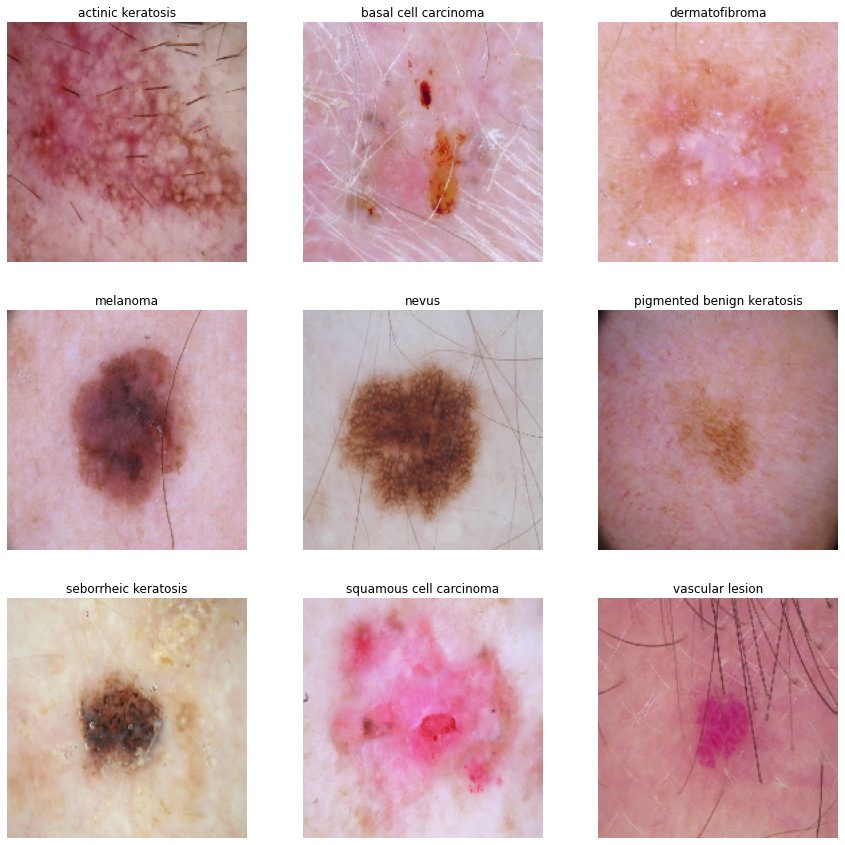

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

class_dict = {}
plt.figure(figsize=(15,15))
i = 0
for c in class_names:
  path = os.path.join("/content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/",c)
  class_dict[c] = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))])
  image_path = os.path.join(path,os.listdir(path)[0])
  i+=1
  plt.subplot(3,3,i)
  plt.imshow(load_img(image_path,target_size=(180,180)))
  plt.title(c)
  plt.axis("off")

print(class_dict)


                        class  count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


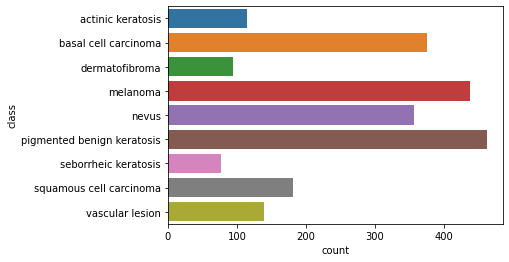

In [11]:
import seaborn as sns

class_df = pd.DataFrame()
class_df["class"] = class_dict.keys()
class_df["count"] = class_dict.values()

print(class_df)

sns.barplot(x="count", y="class", data=class_df,
            label="Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
image_count = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count)

0


### Create the model
#### A CNN model, which can accurately detect 9 classes present in the dataset. ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

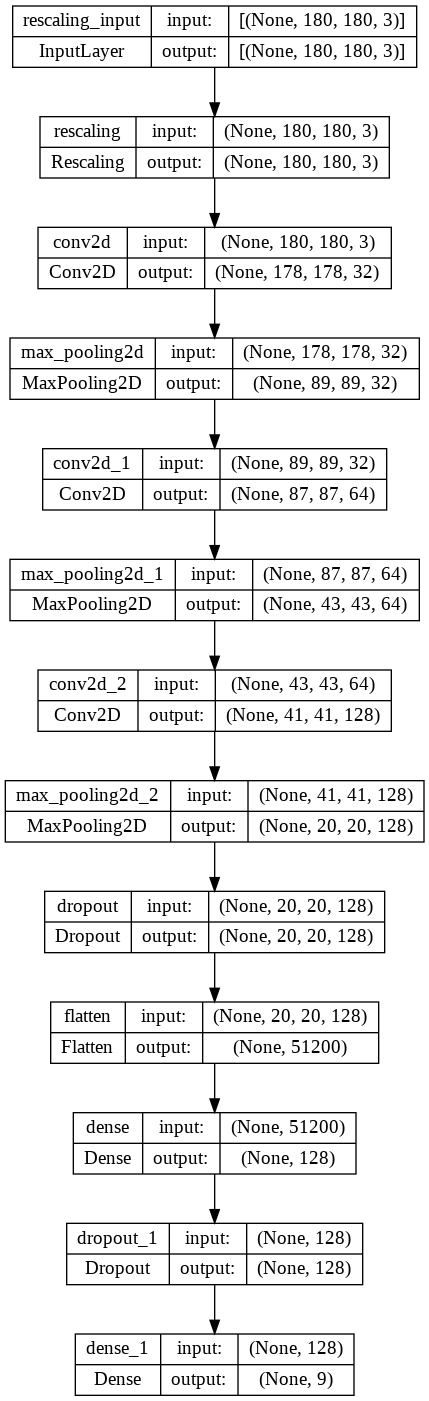

In [16]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
#Compile the Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#Adam optimization: stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: loss function for multi-class classification

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',subset='training',seed=123,validation_split=0.2)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8705
Epoch 1: val_accuracy improved from -inf to 0.54139, saving model to model.h5
56/56 [==============================] - 19s 271ms/step - loss: 0.3293 - accuracy: 0.8705 - val_loss: 2.5760 - val_accuracy: 0.5414
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8875
Epoch 2: val_accuracy did not improve from 0.54139
56/56 [==============================] - 18s 293ms/step - loss: 0.2842 - accuracy: 0.8873 - val_loss: 2.6961 - val_accuracy: 0.5414
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9023
Epoch 3: val_accuracy did not improve from 0.54139
56/56 [==============================] - 17s 280ms/step - loss: 0.2401 - accuracy: 0.9023 - val_loss: 2.6466 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.8906
Epoch 4: val_accuracy did not improve from 0.541

### Visualizing training results

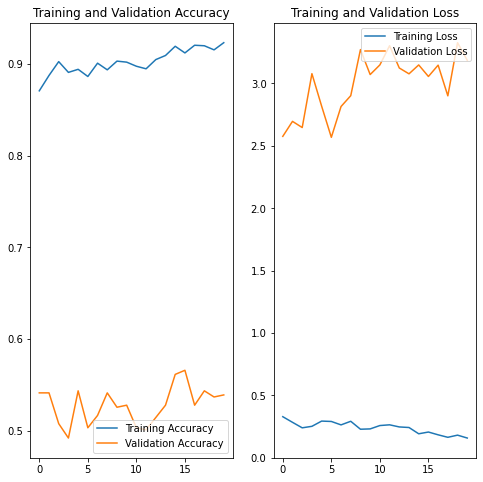

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit

1/1 [==============================] - 1s 556ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


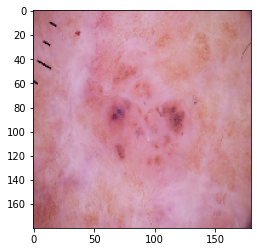

In [30]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

### Write your findings here

Model tends to underfit, hence we will use data augmentation strategy


In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

#Handling imbalance using augmentor 
train_path="/content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(train_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5BACDC5D90>: 100%|██████████| 500/500 [00:21<00:00, 23.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B96613910>: 100%|██████████| 500/500 [00:18<00:00, 26.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5B964FD5E0>: 100%|██████████| 500/500 [00:20<00:00, 23.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5C7C81B3A0>: 100%|██████████| 500/500 [01:40<00:00,  5.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F5BAC9B3C70>: 100%|██████████| 500/500 [01:23<00:00,  5.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5BACBFD250>: 100%|██████████| 500/500 [00:19<00:00, 25.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5C14E741F0>: 100%|██████████| 500/500 [00:44<00:00, 11.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B9684F460>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5BACC1E4C0>: 100%|██████████| 500/500 [00:19<00:00, 25.58 Samples/s]


{'actinic keratosis': 614, 'basal cell carcinoma': 876, 'dermatofibroma': 595, 'melanoma': 938, 'nevus': 857, 'pigmented benign keratosis': 962, 'seborrheic keratosis': 577, 'squamous cell carcinoma': 681, 'vascular lesion': 639}
                        class  count
0           actinic keratosis    614
1        basal cell carcinoma    876
2              dermatofibroma    595
3                    melanoma    938
4                       nevus    857
5  pigmented benign keratosis    962
6        seborrheic keratosis    577
7     squamous cell carcinoma    681
8             vascular lesion    639


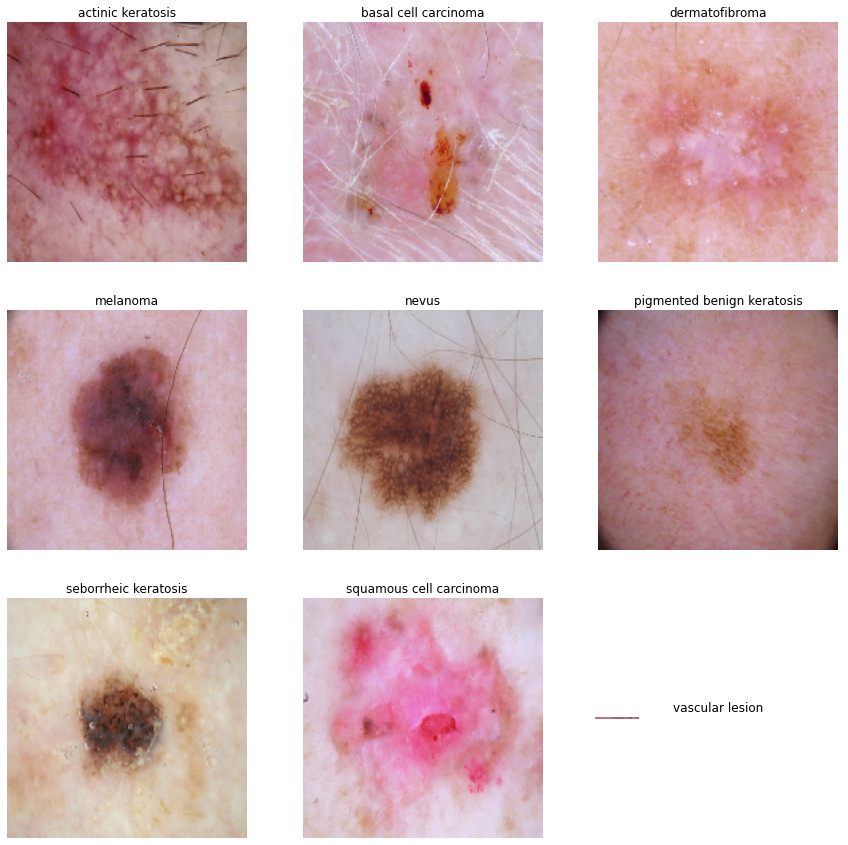

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

class_dict_post_augm = {}
plt.figure(figsize=(15,15))
i = 0
for c in class_names:
  path = os.path.join("/content/gdrive/MyDrive/CNN_Assignment/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/",c)
  #class_dict_post_augm[c] = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))])
  class_dict_post_augm[c] = sum([len(files) for r, d, files in os.walk(path)])
  image_path = os.path.join(path,os.listdir(path)[0])
  i+=1
  plt.subplot(3,3,i)
  plt.imshow(load_img(image_path,target_size=(180,180)))
  plt.title(c)
  plt.axis("off")

print(class_dict_post_augm)

class_df_post = pd.DataFrame()
class_df_post["class"] = class_dict_post_augm.keys()
class_df_post["count"] = class_dict_post_augm.values()

print(class_df_post)

sns.barplot(x="count", y="class", data=class_df_post,
            label="Class")

### Compiling the model

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',subset='training',seed=123,validation_split=0.2)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [34]:
#Compile the Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#Adam optimization: stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: loss function for multi-class classification

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Training the model

In [ ]:
## Training the model after handling class imbalance 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
168/169 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9241
Epoch 1: val_accuracy did not improve from 0.88048
169/169 [==============================] - 35s 200ms/step - loss: 0.1963 - accuracy: 0.9241 - val_loss: 0.5454 - val_accuracy: 0.8604
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9273
Epoch 2: val_accuracy did not improve from 0.88048
169/169 [==============================] - 34s 193ms/step - loss: 0.1881 - accuracy: 0.9273 - val_loss: 0.5231 - val_accuracy: 0.8582
Epoch 3/20
168/169 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9249
Epoch 3: val_accuracy did not improve from 0.88048
169/169 [==============================] - 35s 200ms/step - loss: 0.1981 - accuracy: 0.9249 - val_loss: 0.4811 - val_accuracy: 0.8708
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9368
Epoch 4: val_accuracy did not improve from 0.88048
169/169 [=

### Visualizing the results

ValueError: ignored

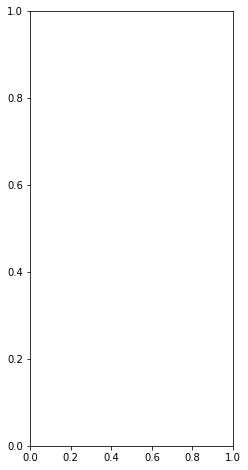

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model has improved by a major margin after applying augmentation.

Class Distribution after augmentation is as:

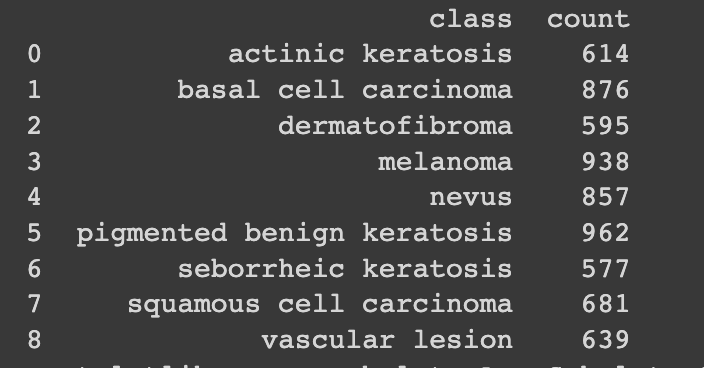


#### - Dermato fibroma class has the least number of samples
#### - Pigmened benign keratosis classes dominate the data in terms of proportionate number of samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()